In [ ]:
import pandas as pd
import matplotlib.animation as ani
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.offsets import *
import numpy as np
import pandas_alive
import math

from plotly.subplots                       import make_subplots
import plotly.express                      as ex
import plotly.graph_objs                   as go
import plotly.offline                      as pyo


import nltk
import seaborn as sns
from tqdm.notebook                         import tqdm


from nltk.corpus import stopwords




from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
#%matplotlib qt

In [ ]:
##readabc
df = pd.read_csv('/Users/jackohagan/datajournalism/abcheadlines/abcnews-date-text.csv',parse_dates=[0], infer_datetime_format=True)

In [ ]:
#convert date to start of month
df['publish_date'] = df['publish_date'].to_numpy().astype('datetime64[M]')


In [ ]:
STOPWORDS =  set(stopwords.words('english'))

In [ ]:
#add words that aren't in the NLTK stopwords list
new_stopwords = ['says','say','australia','australian','2015','2010','2011','2013','2012','2014','2017','2018','2019','2020',
                'january','february','march','april','may','june','july','august','september','october','november','decemeber']
new_stopwords_list = STOPWORDS.union(new_stopwords)

In [ ]:
##REMOVE STOPWORDS

df['headline_text'] = df['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (new_stopwords_list)]))

In [ ]:

#Add year column
df['year']    = pd.DatetimeIndex(df['publish_date']).year

In [ ]:
##uncomment for individual PM
dfgrouped = df.groupby(['publish_date']).count().reset_index()
dfgrouped= dfgrouped[dfgrouped['publish_date'] > '2010-01-01']
dfgrouped.head()

In [ ]:

df= df[df['publish_date'] > '2010-01-01']

yearly = df.groupby('year')['headline_text'].agg(list).to_dict()

In [ ]:
##loop through year images and create simple word clouds

yearlist = [2015,2016,2017,2018,2019,2020]

for i in yearlist: 
    mask = np.array(Image.open('/Users/jackohagan/datajournalism/abcheadlines/{}.jpg'.format(i)))
    wc = WordCloud(mask=mask, background_color="rgba(255, 255, 255, 0)",
                   max_words=150, max_font_size=256,
                   random_state=42, width=mask.shape[1],
                   height=mask.shape[0])

    # use ImageColorGenerator to generate the colors from the image
    image_colors = ImageColorGenerator(mask)
    
    plt.subplot(1, 2, 1)   # Define 3 rows, 2 column, Activate subplot 1. 

    wc.generate(' '.join(yearly.get(i)))
    
    fig = plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig("{}-cloudraw.png".format(i),dpi=1000)

In [ ]:
##simple word clouds not that interesting - create some analytical ones
from tqdm import tqdm #used for progress bar
import math

#list of years
year = df.year.unique()

###create a list of headlines for each year using a list comprehension
corpus = [' '.join(df[(df.year==years)].headline_text.tolist()) for years in year]


# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate a CountVectorizer object
# utilize the new STOP_WORDS list
cv=CountVectorizer( stop_words=new_stopwords_list, ngram_range=(1, 2))


In [ ]:

# fit transform our text and create a dataframe with the result
X = cv.fit_transform(corpus)
X = X.toarray()

bow=pd.DataFrame(X, columns = cv.get_feature_names())
bow.index=year

##filter to have at least 25 mentions
bow = bow.loc[:, (bow.sum() >= 25)]


In [ ]:
##credit to https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

from tqdm import tqdm #used for progress bar
import math

#build an empty dataframe
t_bow_df=pd.DataFrame()

# By years, divide the number of times a word is said, 
# by the total number of times they've said all the words that they have said (frequency)
bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1) 

for years in tqdm(year):
    feat_s = bow[bow.index != years].sum()+1 #sum all the times each word was said excluding current years
    feat_s_all = np.sum(bow[bow.index != years].sum()) # all the total words that were said, excluding the current years
    tot = feat_s / feat_s_all #find the frequency of words said among other years
    row = bow_transformed.loc[years] / tot #divide the years array of frequency of words by all other years' frequency
    row = pd.DataFrame(row).T #create a df, and transform
    results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency
    
    t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[years])]) #append to df


In [ ]:

t_bow_df.head(50)

In [ ]:
yearlist = [2015,2016, 2017,2018, 2019, 2020]


for i in yearlist: 
    mask = np.array(Image.open('/Users/jackohagan/datajournalism/abcheadlines/{}.jpg'.format(i)))
    wc = WordCloud(mask=mask, background_color="rgba(255, 255, 255, 0)",
                   max_words=200, max_font_size=256,
                   random_state=42, width=mask.shape[1],
                   height=mask.shape[0], )

    # use ImageColorGenerator to generate the colors from the image
    image_colors = ImageColorGenerator(mask)

    text2_dict=t_bow_df.loc[i].sort_values(ascending=False).to_dict()

    wc.generate_from_frequencies(text2_dict)

    fig = plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig("{}-cloud_25.png".format(i),dpi=1000)

In [ ]:
##top words per year
yearly = df.groupby(['year'], as_index = False).agg({'headline_text': ' '.join})

yearly_n1_word =[]
yearly_n2_word =[]
yearly_n3_word =[]
yearly_n4_word =[]
yearly_n5_word =[]



yearly_word_freqs = []
for year in tqdm(yearly.year):
    F = nltk.FreqDist([i for i in ' '.join(yearly.query(f'year=={year}').headline_text).split() if i not in new_stopwords_list])
    yearly_word_freqs.append(F)
    result = [i for i in F.most_common(10)]
    yearly_n1_word.append(result[0])
    yearly_n2_word.append(result[1])
    yearly_n3_word.append(result[2])
    yearly_n4_word.append(result[3])
    yearly_n5_word.append(result[4])
   

In [ ]:
sns.lineplot(data=df, x='publish_date', y='headline_text')

In [ ]:
#what are the top words each year?

yearly_n1_word =[]
yearly_n2_word =[]
yearly_n3_word =[]

yearly_word_freqs = []
for year in tqdm(yearly.year):
    F = nltk.FreqDist([i for i in ' '.join(yearly.query(f'year=={year}').text).split() if i not in STOPWORDS])
    yearly_word_freqs.append(F)
    result = [i for i in F.most_common(3)]
    yearly_n1_word.append(result[0])
    yearly_n2_word.append(result[1])
    yearly_n3_word.append(result[2])
    

In [ ]:
df['publish_date'] = df['publish_date'] + Week(weekday=0)
df['publish_date'] 
df.head()

In [ ]:
df= df[df['publish_date'] > '2007-01-01']

In [ ]:
##sentiment of different politicans - word cloud?
##word cloud for different politicians

##topics that come up



In [ ]:
##ADD Booleans for selecting headlines
df['Scott Morrison'] = df['headline_text'].str.contains("scott morrison")
df['Melbourne'] = df['headline_text'].str.contains("melbourne")
df['Sydney'] = df['headline_text'].str.contains("sydney")
df['Adelaide'] = df['headline_text'].str.contains("adelaide")
df['Brisbane'] = df['headline_text'].str.contains("brisbane")
df['Hobart'] = df['headline_text'].str.contains("hobart")
df['Perth'] = df['headline_text'].str.contains("perth")
df['Canberra'] = df['headline_text'].str.contains("canberra")
df['scomo'] = df['headline_text'].str.contains("scomo")
df['Malcolm Turnbull'] = df['headline_text'].str.contains("malcolm turnbull")

df['albanese'] = df['headline_text'].str.contains("albanese")

df['Kevin Rudd'] = df['headline_text'].str.contains("kevin rudd")

df['Julia Gillard'] = df['headline_text'].str.contains("julia gillard")

df['Tony Abbott'] = df['headline_text'].str.contains("tony abbott")

df['murdoch'] = df['headline_text'].str.contains("murdoch")

df['robodebt'] = df['headline_text'].str.contains("robodebt")

df['robodebt'] = df['headline_text'].str.contains("robodebt")


df['sausage'] = df['headline_text'].str.contains("sausage")

Dataset appears to have been cleaned up slightly, possibly removing stop words. we find on ABC website the article name might be:

What changes to national security is Tony Abbott proposing?

but our dataset has 


what changes to national security is tony abbott

In [ ]:
df[df['sausage'] == True]

Visualise trends over time, by date - animated graph


In [ ]:
from nltk.corpus import stopwords
stopwords.words("english")

In [ ]:
dfgrouped = df.groupby(['publish_date']).sum().cumsum()
dfgrouped.head()

In [ ]:
dfgroupedselected = dfgrouped[['Kevin Rudd','Julia Gillard','Tony Abbott','Malcolm Turnbull','Scott Morrison']]

In [ ]:
##plot animated for politicians
dfgroupedselected.plot_animated("abc-count-politicians.gif",    figsize=(6.5*1.5, 3.5*1.5),
                     title="Cumulative ABC Headlines",
                     kind='line',
                                period_label=False,
                               steps_per_period=1, interpolate_period=False, period_length=50,
                                 label_events={
        'Morrison PM':datetime.strptime("24/08/2018", "%d/%m/%Y"),
        'Turnbull PM':datetime.strptime("15/09/2015", "%d/%m/%Y"),
        'Abbott PM':datetime.strptime("18/09/2013", "%d/%m/%Y"),
        'Rudd 2nd term':datetime.strptime("27/06/2013", "%d/%m/%Y"),
        'Gillard PM':datetime.strptime("24/06/2010", "%d/%m/%Y"),
        'Rudd PM':datetime.strptime("03/12/2007", "%d/%m/%Y")},
    dpi=500)

In [ ]:
##group for cities
dfgrouped = df.groupby(['publish_date']).sum().cumsum()

##cities
dfgroupedselected = dfgrouped[['Sydney','Melbourne','Adelaide','Hobart', 'Canberra']]



In [ ]:
##plot animated for cities
dfgroupedselected.plot_animated("abc-count-cities.gif",    figsize=(6.5*1.5, 3.5*1.5),
                     title="Cumulative ABC Headlines",
                     kind='line',
                                period_label=False, enable_progress_bar = True,
                               steps_per_period=1, interpolate_period=False, period_length=50,
    dpi=500)

In [85]:
dfgrouped = df.groupby(['publish_date'])['headline_text'].count().reset_index()

dfgrouped.rename(columns={"publish_date": "Publish Date", "headline_text": "Headline Count"},inplace=True)

In [86]:
dfgrouped.head(50)

,Publish Date,Headline Count
0,2010-02-08,5890
1,2010-03-08,6637
2,2010-04-05,6030
3,2010-05-03,6244
4,2010-06-07,6270
5,2010-07-05,6427
6,2010-08-02,6473
7,2010-09-06,6171
8,2010-10-04,6265
9,2010-11-08,6299


/var/folders/_9/dygt4j8d1s1197cm8ymg58cm0000gn/T/ipykernel_1766/2173887639.py:10: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



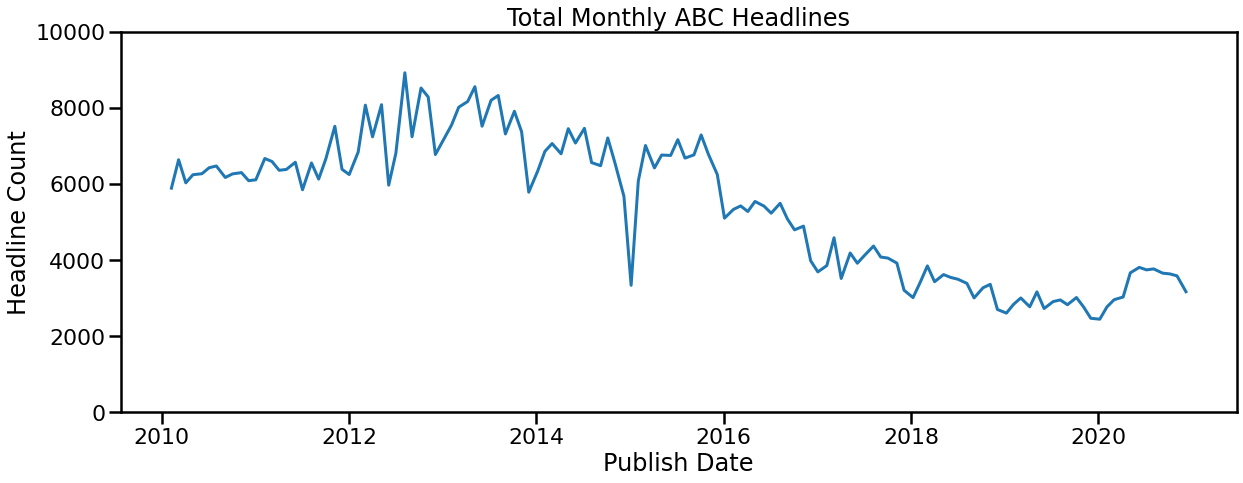

In [106]:

sns.set_context('poster')

plt.rcParams['figure.figsize']=(20,7)
plt.ylim(0, 10000)
plot = sns.lineplot(data=dfgrouped, x='Publish Date',y='Headline Count'
              ).set(title='Total Monthly ABC Headlines')


plt.savefig("abcheadlines.png",bbox_inches='tight')
plt.show()